### Control Lab equipment remotely
* Sun EC13 temperature chamber
* CAEN N6724 digitizer
* CAEN N14171HV supply

In [1]:
# setup
import sys
CRANEPATH = '/opt/cranelab/CraneLab-build/'
CRANEPATH = '/home/achim/gaps/CraneLab/build'
if sys.path[-1] != CRANEPATH:
    sys.path.append(CRANEPATH)

import numpy as np
from skippylab.instruments.powersupplies import CAENN1471HV
from skippylab.instruments.climate_chambers import SunChamber
from skippylab.controllers import PrologixUsbGPIBController, ZMQController
from skippylab.controllers import SimpleSocketController
from skippylab.controllers import TelnetController

from skippylab.instruments.patchpannels import Cytec
import pyCaenN6725

Can not use adafruit dht sensors on this machine. Try installing requirements with pip3 install Adafruit_DHT


In [2]:
patchp = Cytec(TelnetController("192.168.1.7", 8081))

In [4]:
patchp.get_current_settings()
#patchp._controller.write(" ifconfig 192.168.1.7 255.255.255.0")

'F1\r\nA0, E0, V0\r\nBaudnumber = 6, RS Handshaking = 1\r\nGPIB = 7\r\nIP Address = 192.168.1.7\r\nNetmask = 255.255.255.0\r\nGateway = 0.0.0.0\r\nPort0 = 8080, Port1 = 8081\r\nTCP idle = 60\r\nTelnetlock = 0, Telnet Echo = 0\r\nBattery Ram = 0, Default List = 0\r\n0'

In [65]:
patchp.show_matrix()

['0000000000000000\r\n0000000000000000\r\n0000000000000000\r\n1111000000000000\r\n0000000000000000\r\n0000000000000000\r\n0000000000000000\r\n1111000000000000\r\n0']

In [5]:
patchp.latch_detector(0)

In [3]:
patchp.unlatch_all()

<CytecPatchPannelStatus.SUCCESS_OPEN: '0'>

### Operate the high voltage

In [8]:
# currently the hv is connected via USB
# (will change to e0ternet at some point)
HVPORT='/dev/ttyACM0'
#HVPORT='/dev/serial/by-id/usb-CAEN_SPA_NIM_Desktop_HV_Power_Supply-if00'
#HVPORT = '/dev/usb/'
LOGLEVEL=30
try:
    hv = CAENN1471HV(port=HVPORT,
                                 loglevel=LOGLEVEL,
                                 time_delay=1.0)
except Exception as e:
    print(e)
    print ('Exception caught, try executing the cell again!')


In [32]:
# do something - activate the power

hv.channel0.voltage_as_set = 250
hv.channel0.current_as_set = 100.0 # 10 micro amps
hv.channel0.ramp_up = 3
hv.channel0.ramp_down = 3
hv.channel0.activate()


([5.02939595800126,
  8.037385169998743,
  11.041367137993802,
  14.04683230300725,
  17.052024748001713,
  20.05733515000611,
  23.06250163000368,
  26.06983582000248,
  29.075049385006423,
  32.080117799996515,
  35.08828158500546,
  38.096099399001105,
  41.10128920900752,
  44.10724120600207,
  47.11207160400227,
  50.121411398999044,
  53.1271498559945,
  56.136024551000446,
  59.14128716599953,
  62.14643661100126,
  65.15138846400077,
  68.15620602900162,
  71.16406808899774,
  74.1716881320026,
  77.17602961299417,
  80.18130788199778,
  83.18653845399967,
  86.19198682700517,
  89.20005048399616,
  92.20534254399536,
  95.21060447400669,
  98.21565233300498,
  101.220009148994,
  104.22791876300471,
  107.2343837130029,
  110.23959301700233,
  113.24379387400404,
  116.24780221800029,
  119.25209987499693,
  122.26029165499494,
  125.26829432899831,
  128.27603064199502,
  131.28134292499453,
  134.28664411400678,
  137.29165635400568,
  140.29598574800184,
  143.3000453790009

In [9]:
# and deactivate
hv.channel0.ramp_down = 3
hv.channel0.deactivate()

KeyboardInterrupt: 

### Operate the SUN EC13 temperature chamber

In [11]:
import time
import numpy as np

SUNPORT = '/dev/ttyUSB1'
SUNPORT='/dev/serial/by-id/usb-Prologix_Prologix_GPIB-USB_Controller_PX30FLUZ-if00-port0'
sunec = SunChamber(PrologixUsbGPIBController(port=SUNPORT),
                                             publish=False,
                                             port=SUNPORT)

SUN EC13 chamber reporting status....
----------------------------------


In [3]:
sunec.ON
print (sunec.get_temperature())
sunec.OFF

Turning on chamber...
-47.01
Turning chamber off...


In [16]:
sunec.ON
sunec.temperature_as_set = 30
#sunec.activate_cooler()
sunec.activate_heater()

Turning on chamber...


In [23]:
# power it on

sunec.ON
sunec.OFF

Turning on chamber...
Turning chamber off...


Turning on chamber...


<IPython.core.display.Javascript object>


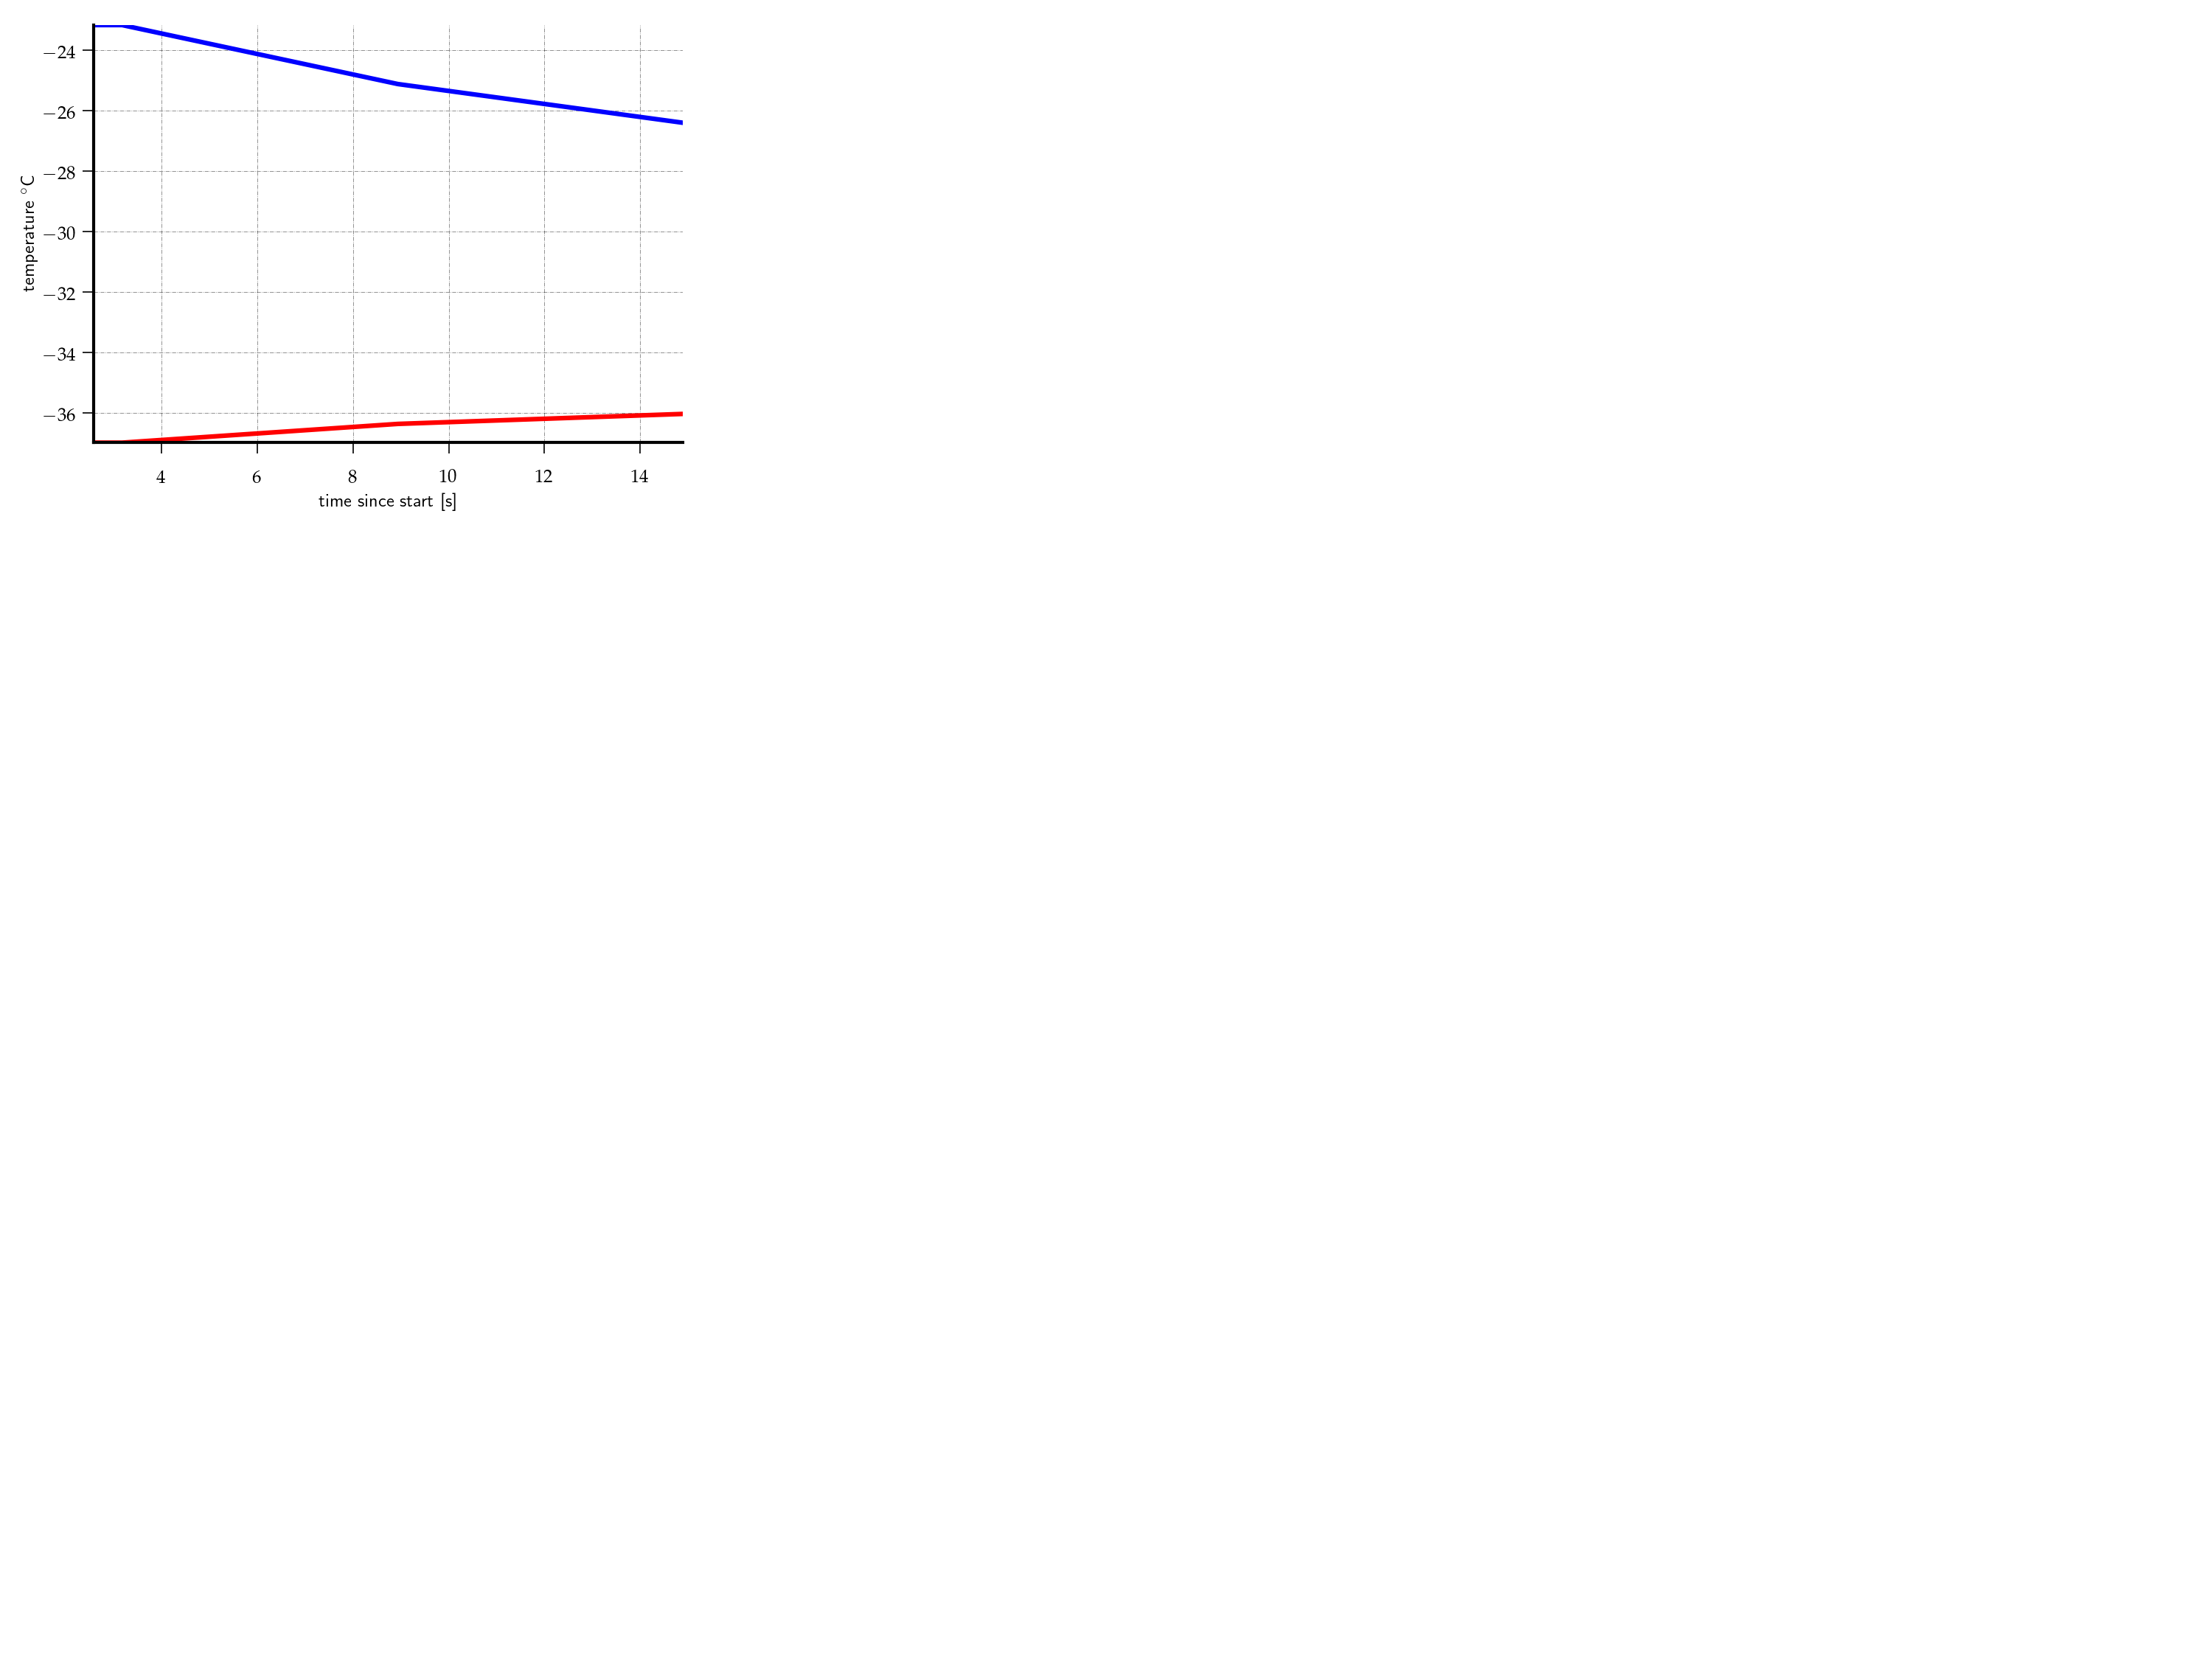

  (prop.get_family(), self.defaultFamily[fontext]))

  (prop.get_family(), self.defaultFamily[fontext]))



In [ ]:
%matplotlib notebook

#cooldown
sunec.ON
sunec.monitor_temperatures(target_temp=-47,
                           activate=True)
sunec.OFF

Turning on chamber...


<IPython.core.display.Javascript object>


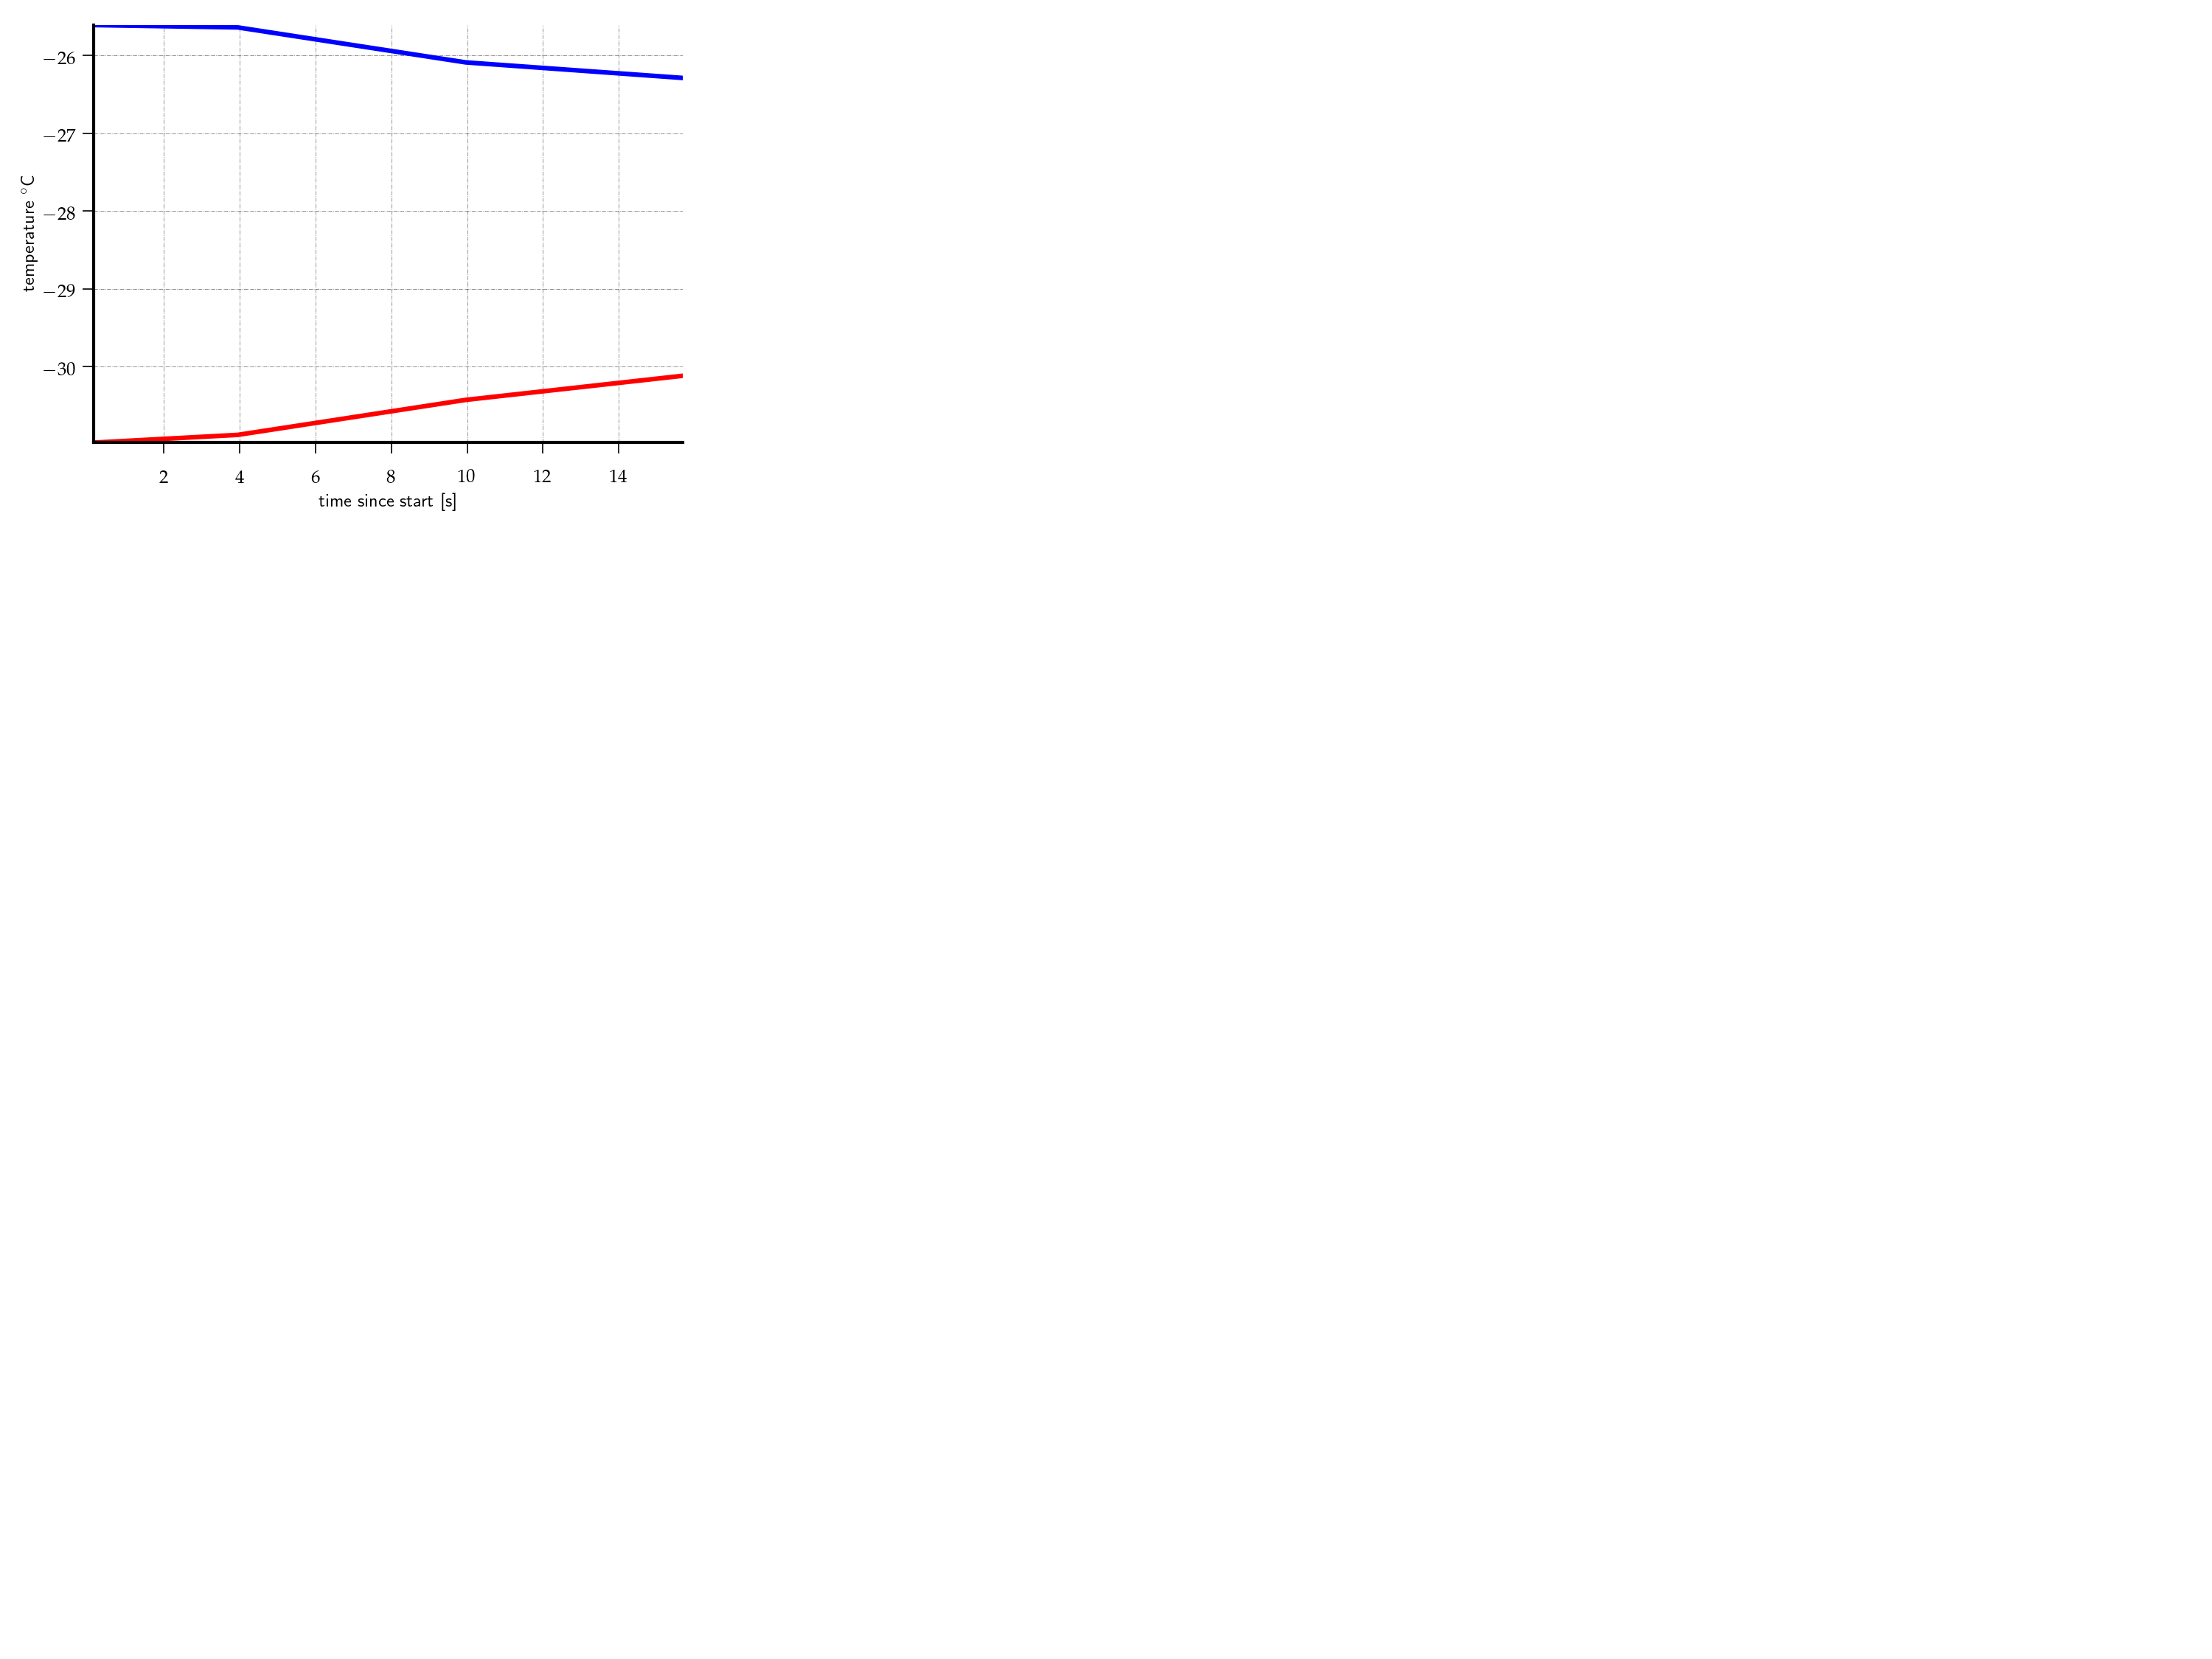

KeyboardInterrupt: 

In [14]:
%matplotlib notebook

# warmup
sunec.ON
sunec.open_dry_nitrogen_valve()
sunec.monitor_temperatures(target_temp=100,
                           activate=True)
sunec.OFF

In [3]:

import CraneLab as cl
import os, os.path
import importlib
importlib.reload(cl)

Welcome to JupyROOT 6.16/00


<module 'CraneLab' from '/home/achim/gaps/CraneLab/build/CraneLab.py'>

In [4]:
rundir = '/home/achim/gaps/lab-data/RUN10'

In [5]:
#del digitizer
digitizer = cl.setup_digitizer(open(os.path.join(rundir,"config_x.json")))

Connected to digitizer model N6725, roc firmware 04.15 - Build 1518,  amc firmware 139.08 - Build 1801
Chan: 0 -  54°C
Chan: 1 -  54°C
Chan: 2 -  54°C
Chan: 3 -  54°C
Chan: 4 -  67°C
Chan: 5 -  67°C
Chan: 6 -  67°C
Chan: 7 -  67°C
Will calibrate the digitizer


In [6]:
cl.run_digitizer(digitizer, 10,
              filename = os.path.join(rundir, 'test1.root'),
              read_waveforms=True)

Starting readout


In [7]:
digitizer.get_n_events_tot()

[956, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
%matplotlib notebook

for i in range(10):
    cl.run_digitizer(digitizer, 60,
                    filename = os.path.join(rundir, "test" + str(i) + ".root"),
                    read_waveforms=True)
    print (digitizer.get_n_events_tot())
    sunec.ON
    sunec.monitor_temperatures(target_temp=-47,
                           activate=True)
    sunec.OFF
    

  % get_backend())

  (prop.get_family(), self.defaultFamily[fontext]))



[5348, 0, 0, 0, 0, 0, 0, 0]
Turning on chamber...


  (prop.get_family(), self.defaultFamily[fontext]))



### Try the oscilloscope as a DAQ

In [ ]:
import skippylab.instruments.oscilloscopes as osc

rs = osc.RhodeSchwarzRTO1044('192.168.1.6')
print(rs.ping())
rs.instrument.ask("*IDN?")

In [ ]:
rs.active_channel

In [ ]:
rs.ACQUIRE_ONE

In [ ]:
rs.acquire_waveform?

In [ ]:
rs.do_single_acquisition?

In [ ]:
rs.acquire_waveform()

In [ ]:
origin = rs.instrument.ask('CHANnel1:DATA:XORigin?')
xincre = rs.instrument.ask('CHANnel1:DATA:XINC?')
print (origin)
print (xincre)
alldata = []

In [ ]:
import tqdm
import pickle

for k in range(50):
    #sunec.OFF
    alldata = []
    for i in range(100):
        print(k,i)
        rs.instrument.write("RUNSingle")
        rs.instrument.write('ACQuire:NSINgle:COUNt 1')
        #time.sleep(1)
        while(True):

            finished = rs.instrument.ask('ACQuire:STATe?')
            #print(finished)
            time.sleep(0.2)
            if (finished == "COMP"):
                data = rs.instrument.ask("CHAN1:DATA?")
                #print (data[:12])
                alldata.append(data)
                break
            #if (finished == "STOP"):
           #     print ('stopped')
           #     try:
           #         data = rs.instrument.ask("CHAN1:DATA?")
           #         print (data[:12])
           #         alldata.append(data)
           #         break
           #     except Exception as e:
           #         print (e)
           #         continue

    datatosave = dict()
    datatosave['xorig'] = origin
    datatosave['xincr'] = xincre
    datatosave['volts'] = alldata
    try:
        filetosavepi = open(f'/home/achim/xray{k}.pickle', "xb")
    except:
        filetosavepi = open(f'/home/achim/xrayA{k}.pickle', 'xb')
    pickle.dump(datatosave, filetosavepi)
    filetosavepi.close()
    
    #delta_t = 0
    #start = time.monotonic()
    #sunec.ON
    #temp = sunec.get_temperature()
    #while (not (np.isfinite(temp))):
    #    temp = sunec.get_temperature()
    #while temp > -42:
    #    print (temp)
    #    sunec.ON
    #    sunec.activate_cooler()
    #    sunec.deactivate_heater()

    #    sunec.rate_as_set = 3
    #    sunec.temperature_as_set = -45
    #    time.sleep(20)
    #    temp = sunec.get_temperature()
    #    while (not (np.isfinite(temp))):
    #        temp = sunec.get_temperature()
    #sunec.OFF

In [ ]:
temp

In [ ]:
print (len(alldata))
import pickle
import hjson

datatosave = dict()
datatosave['xorig'] = origin
datatosave['xincr'] = xincre
datatosave['volts'] = alldata
filetosavepi = open('/home/achim/firstmuons.pickle', "xb")
filetosavehj = open('/home/achim/firstmuons.json', 'w')
hjson.dump(datatosave, filetosavehj)
pickle.dump(datatosave, filetosavepi)
filetosavepi.close()
filetosavehj.close()

In [ ]:
file = open()

In [ ]:
data = rs.instrument.ask("CHAN1:DATA?")